# DETECCION DE PEATONES CON HOG Y SVM


# Navegación Autónoma – MR4010

Actividad 3.1 - Detección de Peatones con SVM.

EQUIPO 21

- ELMER JIMÉNEZ HERNÁNDEZ - A01795128
- JONATHAN LUNA HERNÁNDEZ - A01795072
- FRANCISCO JAVIER RUPIT OLVERA - A01795106
- RUBÉN DÍAZ GARCÍA - A01371849

CAMPUS: EN LÍNEA (C.E.M.)


#### PROFESOR TITULAR: DR. DAVID ANTONIO TORRES
#### PROFESOR ASISTENTE: MTRA. MARÍA MYLEN TREVIÑO ELIZONDO
#### PROFESOR TUTOR: ARTURO DANIEL SOSA

In [2]:
import matplotlib.image as mpimg  # Importación de librerías
import matplotlib.pyplot as plt  # Importación de librerías
import numpy as np  # Importación de librerías
import seaborn as sns  # Importación de librerías
import cv2  # Importación de librerías
from skimage.feature import hog  # Importación de librerías
from skimage import exposure  # Importación de librerías
from sklearn.metrics import confusion_matrix  # Importación de librerías

### Se importan los dos datasets 


In [ ]:
import glob  # Importación de datos
ped = glob.glob(r"C:\Users\frank\Downloads\TrainingData\Pedestrians\48x96\*.pgm")
no_ped = glob.glob(r"C:\Users\frank\Downloads\TrainingData\NonPedestrians\*.pgm")

In [4]:
print("Cantidad de imagenes con porsonas: ",len(ped))
print("Cantidad de imagenes sin personas: ",len(no_ped))

Cantidad de imagenes con porsonas:  15660
Cantidad de imagenes sin personas:  6744


### Se muestra la imagen de una persona

Text(0.5, 1.0, 'Imagen de prueba')

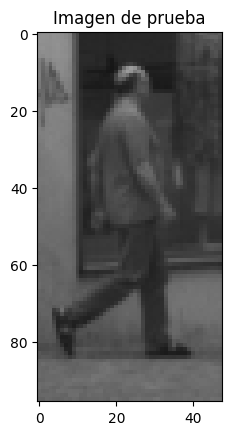

In [5]:
img= cv2.imread(ped[200])  # Leer imagen desde la ruta especificada
plt.imshow(img)  # Mostrar imagen con Matplotlib
plt.title("Imagen de prueba")  # Título de la imagen mostrada

### Demostración del calculo de HOG en la imagen

In [ ]:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  # Convierte la imagen de BGR a escala de grises, necesario para HOG

# Calcula los descriptores HOG (Histogram of Oriented Gradients) de la imagen en escala de grises
features, hog_img = hog(
    img_gray,
    orientations=16,           # Número de orientaciones para los gradientes
    pixels_per_cell=(6, 6),    # Tamaño de cada celda en píxeles
    cells_per_block=(1, 1),    # Número de celdas por bloque
    transform_sqrt=False,      # No aplica la transformación de raíz cuadrada
    visualize=True,            # Devuelve también la imagen HOG para visualización
    feature_vector=True        # Devuelve el vector de características en formato plano
)

print("Cantidad de features: ", features.shape)      # Imprime la cantidad de características extraídas
print("Tamaño de la imagen hog: ", hog_img.shape)    # Imprime el tamaño de la imagen HOG generada

Cantidad de features:  (2048,)
Tamaño de la imagen hog:  (96, 48)


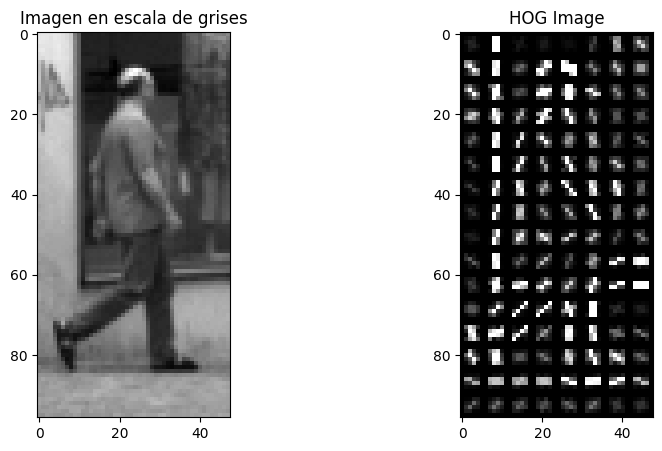

In [7]:
hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_gray,cmap="gray")  # Mostrar imagen con Matplotlib
plt.title("Imagen en escala de grises")  # Título de la imagen mostrada

plt.subplot(1,2,2)
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)  # Mostrar imagen con Matplotlib
plt.title('HOG Image')  # Título de la imagen mostrada

plt.show()  # Mostrar la ventana de la imagen

### Se extraen los features de HOG para las imagenes

#### Imagenes de personas

In [ ]:
# Código para extraer Características.
ped_hog_accum = []

for i in range(len(ped)):
    img1 = cv2.imread(ped[i])  # Leer imagen desde la ruta especificada
    img_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)  # Convertir la imagen de BGR a RGB para mostrarla con Matplotlib
    
    ped_hog_feature, ped_hog_img = hog(img_gray,
                                               orientations = 16,
                                               pixels_per_cell = (6,6),
                                               cells_per_block = (1,1),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    ped_hog_accum.append(ped_hog_feature)  # Agregar elemento a la lista

In [9]:
X_ped = np.vstack(ped_hog_accum).astype(np.float64)
y_ped = np.ones(len(X_ped))

print("Tamaño de X para imagenes de personas: ", X_ped.shape)
print("Tamaño de y para imagenes de personas: ", y_ped.shape)

Tamaño de X para imagenes de personas:  (15660, 2048)
Tamaño de y para imagenes de personas:  (15660,)


#### Imagenes sin personas

In [ ]:
noped_hog_accum = []  # Lista para acumular los vectores de características HOG de imágenes sin personas
ancho_dest = 48       # Ancho deseado para recortar las imágenes (igual que las de peatones)
alto_dest = 96        # Alto deseado para recortar las imágenes (igual que las de peatones)
for i in range(len(no_ped)):
    img2 = cv2.imread(no_ped[i])  # Leer imagen desde la ruta especificada
    img_gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)  # Convertir la imagen a escala de grises
    ancho, alto = img_gray.shape[1], img_gray.shape[0]  # Obtener dimensiones originales de la imagen
    izquierda = int((ancho - ancho_dest) / 2)           # Calcular coordenada izquierda para recorte centrado
    superior = int((alto - alto_dest) / 2)              # Calcular coordenada superior para recorte centrado
    derecha = izquierda + ancho_dest                    # Calcular coordenada derecha para recorte centrado
    inferior = superior + alto_dest                     # Calcular coordenada inferior para recorte centrado
    img_recortada = img_gray[superior:inferior, izquierda:derecha]  # Recortar la imagen al tamaño deseado
    noped_hog_feature, noped_hog_img = hog(
        img_recortada,
        orientations=16,           # Número de orientaciones para los gradientes
        pixels_per_cell=(6,6),     # Tamaño de cada celda en píxeles
        cells_per_block=(1,1),     # Número de celdas por bloque
        transform_sqrt=False,      # No aplica la transformación de raíz cuadrada
        visualize=True,            # Devuelve también la imagen HOG para visualización
        feature_vector=True        # Devuelve el vector de características en formato plano
    )
    noped_hog_accum.append(noped_hog_feature)  # Agregar el vector de características a la lista

In [ ]:
X_noped = np.vstack(noped_hog_accum).astype(np.float64)  # Convierte la lista de vectores HOG en un arreglo 2D de tipo float64
y_noped = np.zeros(len(X_noped))  # Crea un vector de ceros como etiquetas (0 = sin persona) para cada imagen sin persona

print("Tamaño de X para imagenes sin personas: ", X_noped.shape)  # Imprime el tamaño del arreglo de características
print("Tamaño de y para imagenes sin personas: ", y_noped.shape)  # Imprime el tamaño del vector de etiquetas

Tamaño de X para imagenes sin personas:  (6744, 2048)
Tamaño de y para imagenes sin personas:  (6744,)


### Combinacion de ambos datasets para alimentar el SVM

In [ ]:
X = np.vstack((X_ped, X_noped))  # Une (apila verticalmente) los vectores de características de imágenes con y sin personas en un solo arreglo para el SVM
print("Tamaño de las Xs para el SVM:", X.shape)  # Imprime el tamaño total del arreglo de características

y = np.hstack((y_ped, y_noped))  # Une (apila horizontalmente) los vectores de etiquetas de imágenes con y sin personas en un solo vector
print("Tamaño de las ys para el SVM:", y.shape)  # Imprime el tamaño total del vector de etiquetas

Tamaño de las Xs para el SVM: (22404, 2048)
Tamaño de las ys para el SVM: (22404,)


### Separacion de los datos de entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split  # Importación de la función para dividir los datos

# Separa el conjunto de datos en entrenamiento y prueba.
# X: características (features) de todas las imágenes
# y: etiquetas (1 para peatón, 0 para no peatón)
# test_size=0.3 indica que el 30% de los datos se usarán para prueba y el 70% para entrenamiento
# random_state=42 asegura que la división sea reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Imprime el tamaño de los conjuntos de entrenamiento y prueba para verificar la correcta separación
print("Tamaño de X_train: ", X_train.shape)
print("Tamaño de X_test: ", X_test.shape)

Tamaño de X_train:  (15682, 2048)
Tamaño de X_test:  (6722, 2048)


### Entrenamiento del modelo

In [ ]:
from sklearn.svm import SVC  # Importación de la clase SVC para crear un clasificador de Máquinas de Vectores de Soporte (SVM)

# Se crea una instancia del clasificador SVM
SVM = SVC()

# Entrenamiento del modelo SVM usando los datos de entrenamiento (características y etiquetas)
SVM.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba usando el modelo entrenado
y_predict = SVM.predict(X_test)

### Metricas del modelo

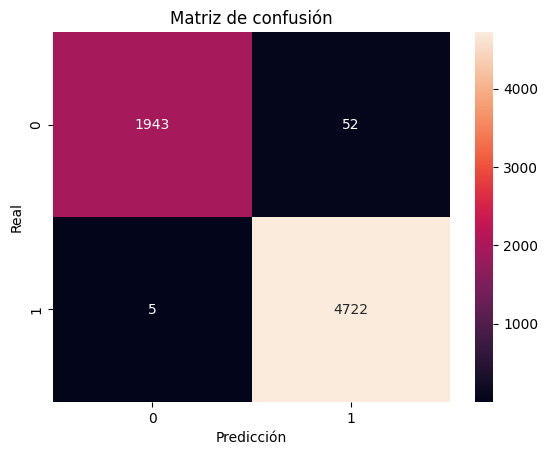

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      1995
         1.0       0.99      1.00      0.99      4727

    accuracy                           0.99      6722
   macro avg       0.99      0.99      0.99      6722
weighted avg       0.99      0.99      0.99      6722



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix  # Importación de librerías para métricas de evaluación

# Definición de la función 'metricas' para evaluar el desempeño del modelo
def metricas(test, predict):
    cm = confusion_matrix(test, predict)  # Calcula la matriz de confusión
    ax = sns.heatmap(cm, annot=True, fmt="d")  # Visualiza la matriz de confusión como un mapa de calor
    ax.set_title("Matriz de confusión")  # Título del gráfico
    ax.set_xlabel("Predicción")          # Etiqueta del eje X
    ax.set_ylabel("Real")                # Etiqueta del eje Y
    plt.show()  # Muestra la gráfica de la matriz de confusión
    print(classification_report(test, predict))  # Imprime el reporte de clasificación con precisión, recall y f1-score

# Llama a la función 'metricas' para mostrar la evaluación del modelo con los datos de prueba
metricas(y_test, y_predict)

### Busqueda de los mejores hiperparametros con GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV  # Importación de la clase para búsqueda de hiperparámetros

# Definición del diccionario de hiperparámetros a probar:
# 'C': Parámetro de penalización del error en SVM
# 'gamma': Parámetro del kernel RBF que controla la influencia de cada muestra
# 'kernel': Tipo de kernel a utilizar, en este caso 'rbf' (función de base radial)
param_grid = {'C': [1, 10, 100], 'gamma': [1,0.1,0.01], 'kernel': ['rbf']} 

# Se crea el objeto GridSearchCV para buscar la mejor combinación de hiperparámetros
# refit=True indica que se reentrenará el modelo con los mejores parámetros encontrados
# verbose=4 muestra información detallada del proceso
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=4)

# Se ajusta (entrena) el modelo GridSearchCV usando los datos de entrenamiento
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.698 total time=22.9min
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.698 total time=27.6min
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.698 total time=24.3min
[CV 4/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.698 total time=32.9min
[CV 5/5] END .........C=1, gamma=1, kernel=rbf;, score=0.698 total time=222.8min
[CV 1/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.795 total time=10.4min
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.793 total time= 8.7min
[CV 3/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.790 total time= 8.7min
[CV 4/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.794 total time= 8.9min
[CV 5/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.795 total time= 8.9min
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.990 total time=  30.1s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf']},
             verbose=4)

In [ ]:
grid.best_params_  # Muestra el mejor conjunto de hiperparámetros encontrados por GridSearchCV.
# Este diccionario indica los valores óptimos de 'C', 'gamma' y 'kernel' que maximizan el rendimiento del modelo SVM
# según la búsqueda realizada en el espacio definido por 'param_grid'.

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [ ]:
grid.best_estimator_  # Muestra el mejor modelo (estimador) encontrado por GridSearchCV.
# Este objeto contiene el clasificador SVM ya entrenado con los hiperparámetros óptimos encontrados,
# listo para ser utilizado en predicciones o evaluaciones adicionales.

SVC(C=10, gamma=0.01)

In [ ]:
grid_predictions = grid.predict(X_test)  # Realiza predicciones sobre el conjunto de prueba usando el mejor modelo encontrado por GridSearchCV.
# Estas predicciones se basan en los hiperparámetros óptimos y permiten evaluar el desempeño final del modelo optimizado.

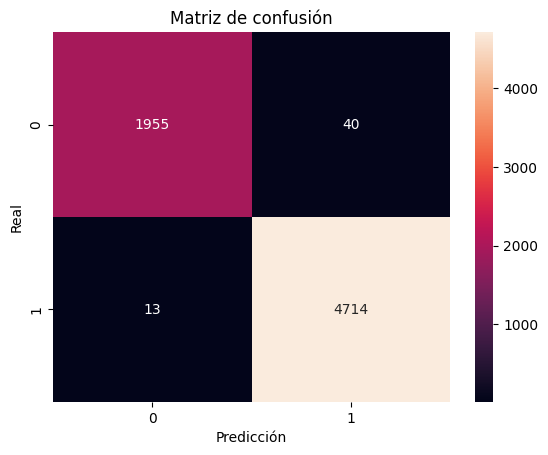

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1995
         1.0       0.99      1.00      0.99      4727

    accuracy                           0.99      6722
   macro avg       0.99      0.99      0.99      6722
weighted avg       0.99      0.99      0.99      6722



In [ ]:
metricas(y_test, grid_predictions)  # Evalúa el desempeño del modelo optimizado usando las métricas definidas.
# Esta función muestra la matriz de confusión y el reporte de clasificación (precisión, recall, f1-score)
# para las predicciones realizadas por el mejor modelo encontrado con GridSearchCV.

In [ ]:
import joblib

# Guardar el mejor estimador
best_svc = grid.best_estimator_
joblib.dump(best_svc, "svc_best_model.joblib")

# Guardar el GridSearchCV completo
joblib.dump(grid, "svc_gridsearch.joblib")

In [ ]:
# Importar el modelo
svc_best = joblib.load("svc_best_model.joblib")
svc_grid = joblib.load("svc_gridsearch.joblib")